# pQCD calculations: Pressure and sound speed squared

## Author: Alexandra Semposki

### Date: 21 March 2024

This interactive Jupyter notebook walks us through the calculation of perturbative QCD (pQCD) using the general form of the pressure, $P(\mu)$, given in [Gorda et al. (2023)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.131.181902), in the Supplemental Material, up to and including N$^{2}$LO. This notebook generates some of the figures in our paper, by A. Semposki, C. Drischler, R. J. Furnstahl, J. A. Melendez, and D. R. Phillips, for the pQCD EOS section.

The first half of this notebook calculates the pressure with respect to the chemical potential, and shows results when BUQEYE truncation error methods are applied to estimate the uncertainties from higher order terms. The second half of the notebook then performs the transformation of this equation to $P(n)$ using the well-known example of Kohn, Luttinger, and Ward (henceforth referred to here as the "KLW inversion" or "KLW method"). The details of theory behind this method can be found in Fetter and Walecka's "Quantum Theory of Many Particle Systems", or in the original papers, found [here](https://journals.aps.org/pr/abstract/10.1103/PhysRev.118.41) and [here](https://journals.aps.org/pr/abstract/10.1103/PhysRev.118.1417). After calculating $P(n)$ up to the same order, we compute the sound speed squared, $c_{s}^{2}(n)$.

This notebook can be easily altered to reflect the pQCD EOS for asymmetric nuclear matter, and also can be modified to include the recent results from [Gorda et al. (2023)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.131.181902) at N$^{3}$LO, if desired. 

#### Table of contents

1. [Calculation of $P(\mu)$](#calc_p_mu)
1. [Calculation of $P(n)$](#calc_p_n)
  1. [Computing the sound speed squared](#cs2) 
  1. [Saving the data for the GP package](#gp_data)

In [55]:
# import packages
%load_ext autoreload
%autoreload 2

import gsum as gm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator
import numpy as np
import numdifftools as ndt
import scipy.stats as stats
from scipy.optimize import fsolve
import os
from IPython.display import Image
import sys
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

sys.path.append('../src')
sys.path.append('../data')

import scipy.integrate as sc
import scipy.optimize as opt
from scipy.interpolate import interp1d
from collections import defaultdict

from pqcd_reworked import PQCD
from truncation_error import Truncation

from scripts import *
setup_rc_params()

%matplotlib inline

edgewidth = 0.3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
# legend plotter from ChEFT code copied here
import sys
sys.path.append('../nuclear-matter-convergence/')  ## for me this is in this repo
from nuclear_matter.graphs import *
from nuclear_matter import lighten_color

# define order list now
orders = [0,1,2]

# plotting assistance
order_labels = ['LO', 'NLO', 'N$^{2}$LO', 'N$^{3}$LO']
color_list = ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.65 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.55) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

## $P(\mu)/P_{FG}(\mu)$ <a id="calc_p_mu"></a>

Here we calculate the scaled pressure, since we will be needing this quantity for the model mixing step of this work. We divide by the Fermi gas pressure.

In [57]:
n0 = 0.16   # fm-3

In [58]:
# coefficient functions
x = np.linspace(0.4, 1.309, 300)  # mu_q for us --> around the range in n we care about
x_B = 3.0*x

X = x[:, None]  # make a 2D version of x to match the input data structure from SciKitLearn
n_orders = 3    # Here we examine the case where we have info on two non-trivial orders (0,1,2)
orders = np.arange(0, n_orders)

# try only using the N2LO coefficient
# This ensures we only analyze the non-trivial information at
# O(Q^2)
excluded = [0]
orders_mask = ~ np.isin(orders, excluded)   # masking orders to exclude them from training

pqcd = PQCD(X=1,Nf=2)

coeffs = np.array([pqcd.c_0(x), pqcd.c_1(x), pqcd.c_2(x)]).T 

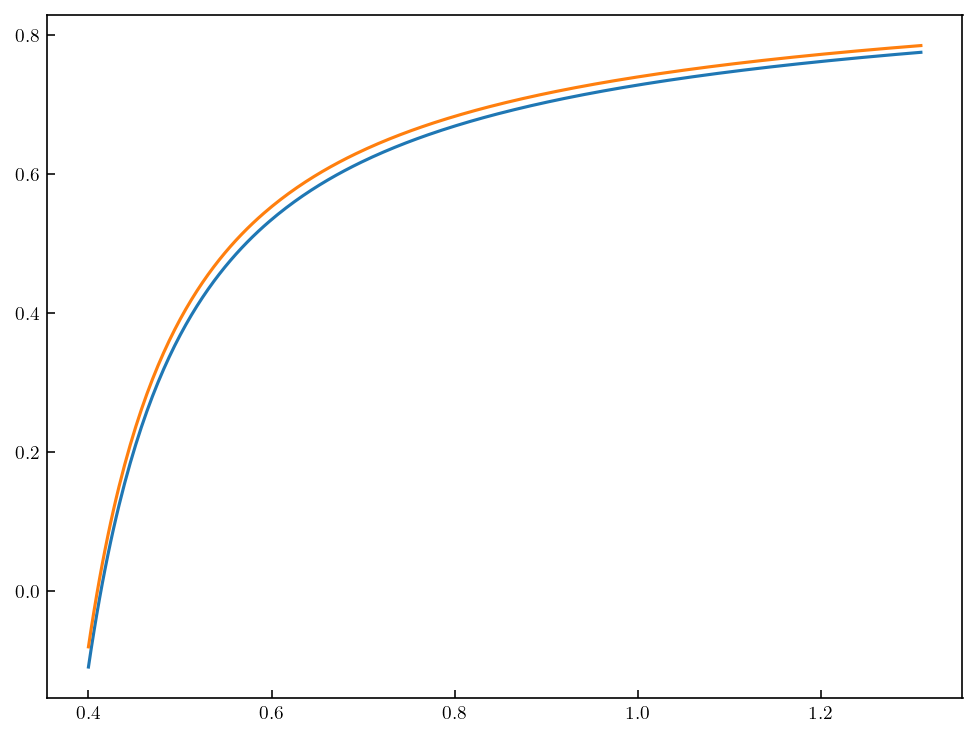

In [59]:
# plot the new and old pressures; should be the same
plt.plot(x, pqcd.pressure_mu(x, order=2)/pqcd.pressure_FG(x))
plt.plot(x, pqcd.pressure_old(x, order=2)/pqcd.pressure_FG(x))

In [60]:
# using the classes to get the results
# employs gsum for interpolation and truncation GPs
# send the orders and mask into the truncation class
trunc = Truncation(x, x_FG=None, norders=3, orders=orders, yref=pqcd.yref, \
                   expQ=pqcd.expQ, coeffs=coeffs, mask=orders_mask)

Text(0.5, 0, '$x$')

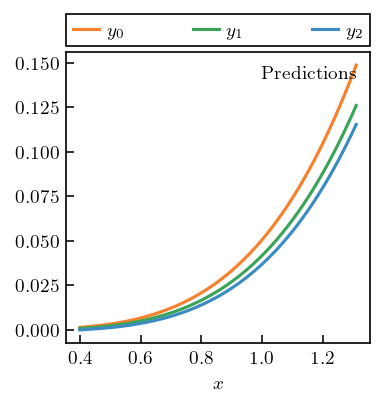

In [61]:
top_legend_kwargs = dict(
    loc='lower left',
    bbox_to_anchor=(0, 1.02, 1, 0.5), ncol=4,
    borderpad=0.37,
    labelspacing=0.,
    handlelength=1.4,
    handletextpad=0.4, borderaxespad=0,
    edgecolor='k',
    mode='expand',
    fancybox=False
)

fig, ax = plt.subplots(1, 1, figsize=(2.45, 2.6))

for i, curve in enumerate(trunc.data.T):
    ax.plot(x, curve, label=r'$y_{}$'.format(i), c=colors[i])

ax.text(0.95, 0.95, 'Predictions', ha='right', va='top',
        transform=ax.transAxes)

legend = ax.legend(**top_legend_kwargs)

# Format
ax.set_xlabel(r'$x$')


Text(0.5, 0, '$x$')

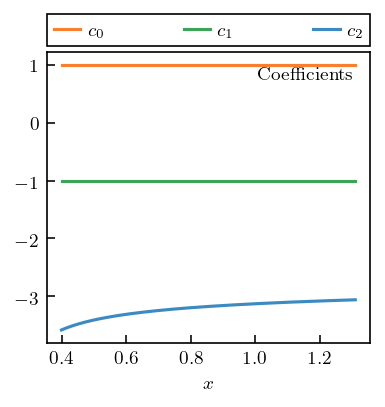

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(2.45, 2.6))

for i,n in enumerate(orders):
    ax.plot(x, trunc.coeffs[:, i], label=r'$c_{}$'.format(i), c=colors[i])

ax.text(0.95, 0.95, 'Coefficients', ha='right', va='top',
           transform=ax.transAxes)

legend = ax.legend(**top_legend_kwargs)

# Format
ax.set_xlabel(r'$x$')

In [63]:
# now fit and predict with the GP (this is directly on the coefficients, so our diagnostics)
pred, std, underlying_std = trunc.gp_interpolation(center=0.0, sd=1.0)

RBF(length_scale=11.3)
4.882312494264722


RBF(length_scale=11.3)
4.882312494264722
2.209595549928702


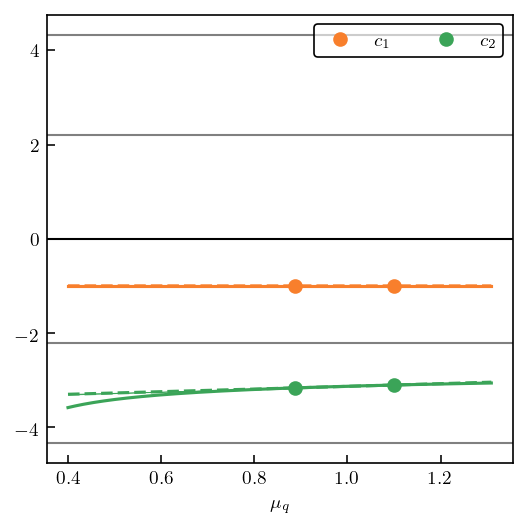

In [64]:
fig, ax = plt.subplots(figsize=(3.4, 3.4), dpi=150)
for i, n in enumerate(orders[1:]):
    ax.plot(x, pred[:, i], c=colors[i], zorder=i-5, ls='--')
    ax.plot(x, trunc.coeffs_trunc[:, i], c=colors[i], zorder=i-5)
  #  ax.plot(x, trunc.coeffs[:, i], c=colors[i], zorder=i-5)
    ax.plot(x[trunc.mask], trunc.coeffs_trunc[trunc.mask, i], c=colors[i], zorder=i-5, ls='', marker='o',
            label=r'$c_{}$'.format(n))
 #   ax.plot(x[trunc.mask], trunc.coeffs[trunc.mask, i], c=colors[i], zorder=i-5, ls='', marker='o',
 #         label=r'$c_{}$'.format(n))
    ax.fill_between(x, pred[:, i] + 2*std, pred[:, i] - 2*std, zorder=i-5,
                     facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth, alpha=1)

print(trunc.gp_interp.kernel_)
print(trunc.gp_interp.cov_factor_)
print(np.sqrt(trunc.gp_interp.cov_factor_))

# Format
ax.axhline(1.96*underlying_std, 0, 1, c='gray', zorder=-10, lw=1)
ax.axhline(-1.96*underlying_std, 0, 1, c='gray', zorder=-10, lw=1)
ax.axhline(1.0*underlying_std, 0, 1, c='gray', zorder=-10, lw=1)
ax.axhline(-1.0*underlying_std, 0, 1, c='gray', zorder=-10, lw=1)
ax.axhline(0, 0, 1, c='k', zorder=-10, lw=1)
ax.set_xlabel(r'$\mu_{q}$')
ax.tick_params(which='minor', bottom=True, top=False)
ax.legend(ncol=2, borderaxespad=0.5, borderpad=0.4)

In [65]:
# data order-by-order P(mu) calculation
data_0 = pqcd.yref(X) * pqcd.c_0(x) 
data_1 = pqcd.yref(X) * (pqcd.c_0(x) + pqcd.c_1(x)*pqcd.expQ(X))
data_2 = pqcd.yref(X) * (pqcd.c_0(x) + pqcd.c_1(x)*pqcd.expQ(X) + pqcd.c_2(x)*pqcd.expQ(X)**2.0)

# compile the orders
data = np.array([data_0, data_1, data_2]).T

# feed to the TruncationGP class and get back the truncation errors (excluding c_0)
data, coeffs, std, cov_1 = trunc.uncertainties(data=data, expQ=pqcd.expQ, yref=pqcd.yref, sd=1.0, \
                                        excluded=[0], nugget=1e-09)
print(trunc.trunc_gp.coeffs_process.cov_factor_)

RBF(length_scale=11.3)
1e-09
4.8823124900208


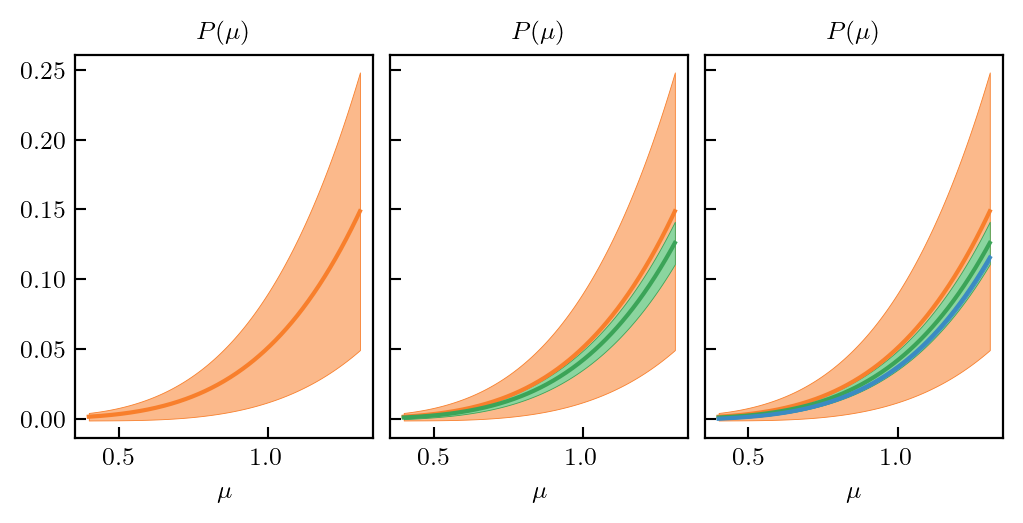

In [66]:
# plot the results here to check the class
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(5, 2.5), dpi=200)

for i, n in enumerate(orders):
    for j in range(i, 3):
        ax = axes.ravel()[j]
        ax.plot(x, data[:, i], zorder=i, c=colors[i])
        ax.fill_between(x, data[:, i] + 1.96*std[:,i], data[:, i] - 1.96*std[:,i],
                        zorder=i-1, facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth)
    ax = axes.ravel()[i]
    ax.set_xlabel(r'$\mu$')
    ax.set_title(r'$P(\mu)$')

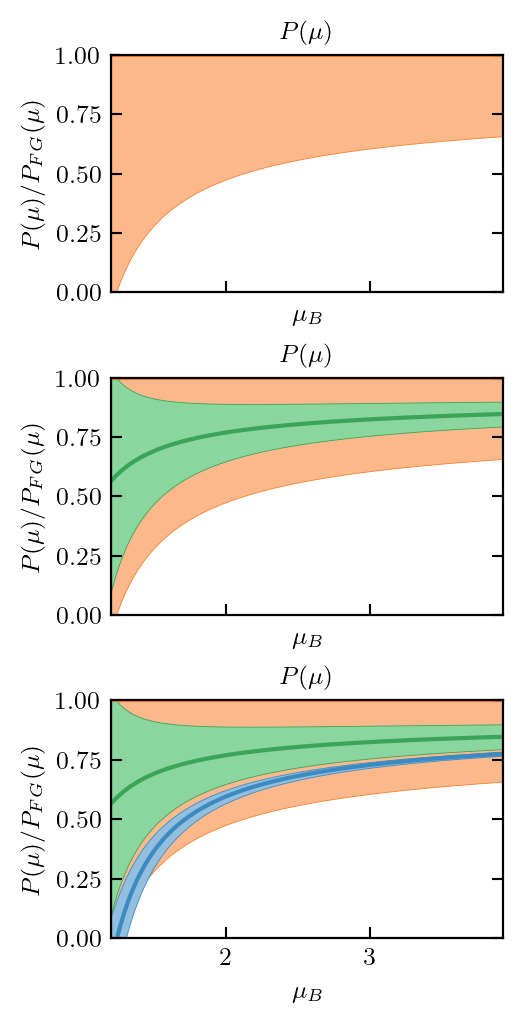

In [67]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(2.5, 5), dpi=200)

for i,n in enumerate(orders):
    for j in range(i, 3):
        ax = axes.ravel()[j]
        ax.plot(x_B, data[:, i]/pqcd.yref(X), zorder=i, c=colors[i])
        ax.fill_between(x_B, (data[:, i] + 1.0*std[:,i])/pqcd.yref(X), (data[:, i] - 1.0*std[:,i])/pqcd.yref(X),
                        zorder=i-1, facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth)
    ax = axes.ravel()[i]
    ax.set_ylim(0,1)
    ax.set_xlim(min(x_B), max(x_B))
    ax.set_xlabel(r'$\mu_{B}$')
    ax.set_ylabel(r'$P(\mu)/P_{FG}(\mu)$')
    ax.set_title(r'$P(\mu)$')
    ax.tick_params(right=True)

0.0002246373462902239


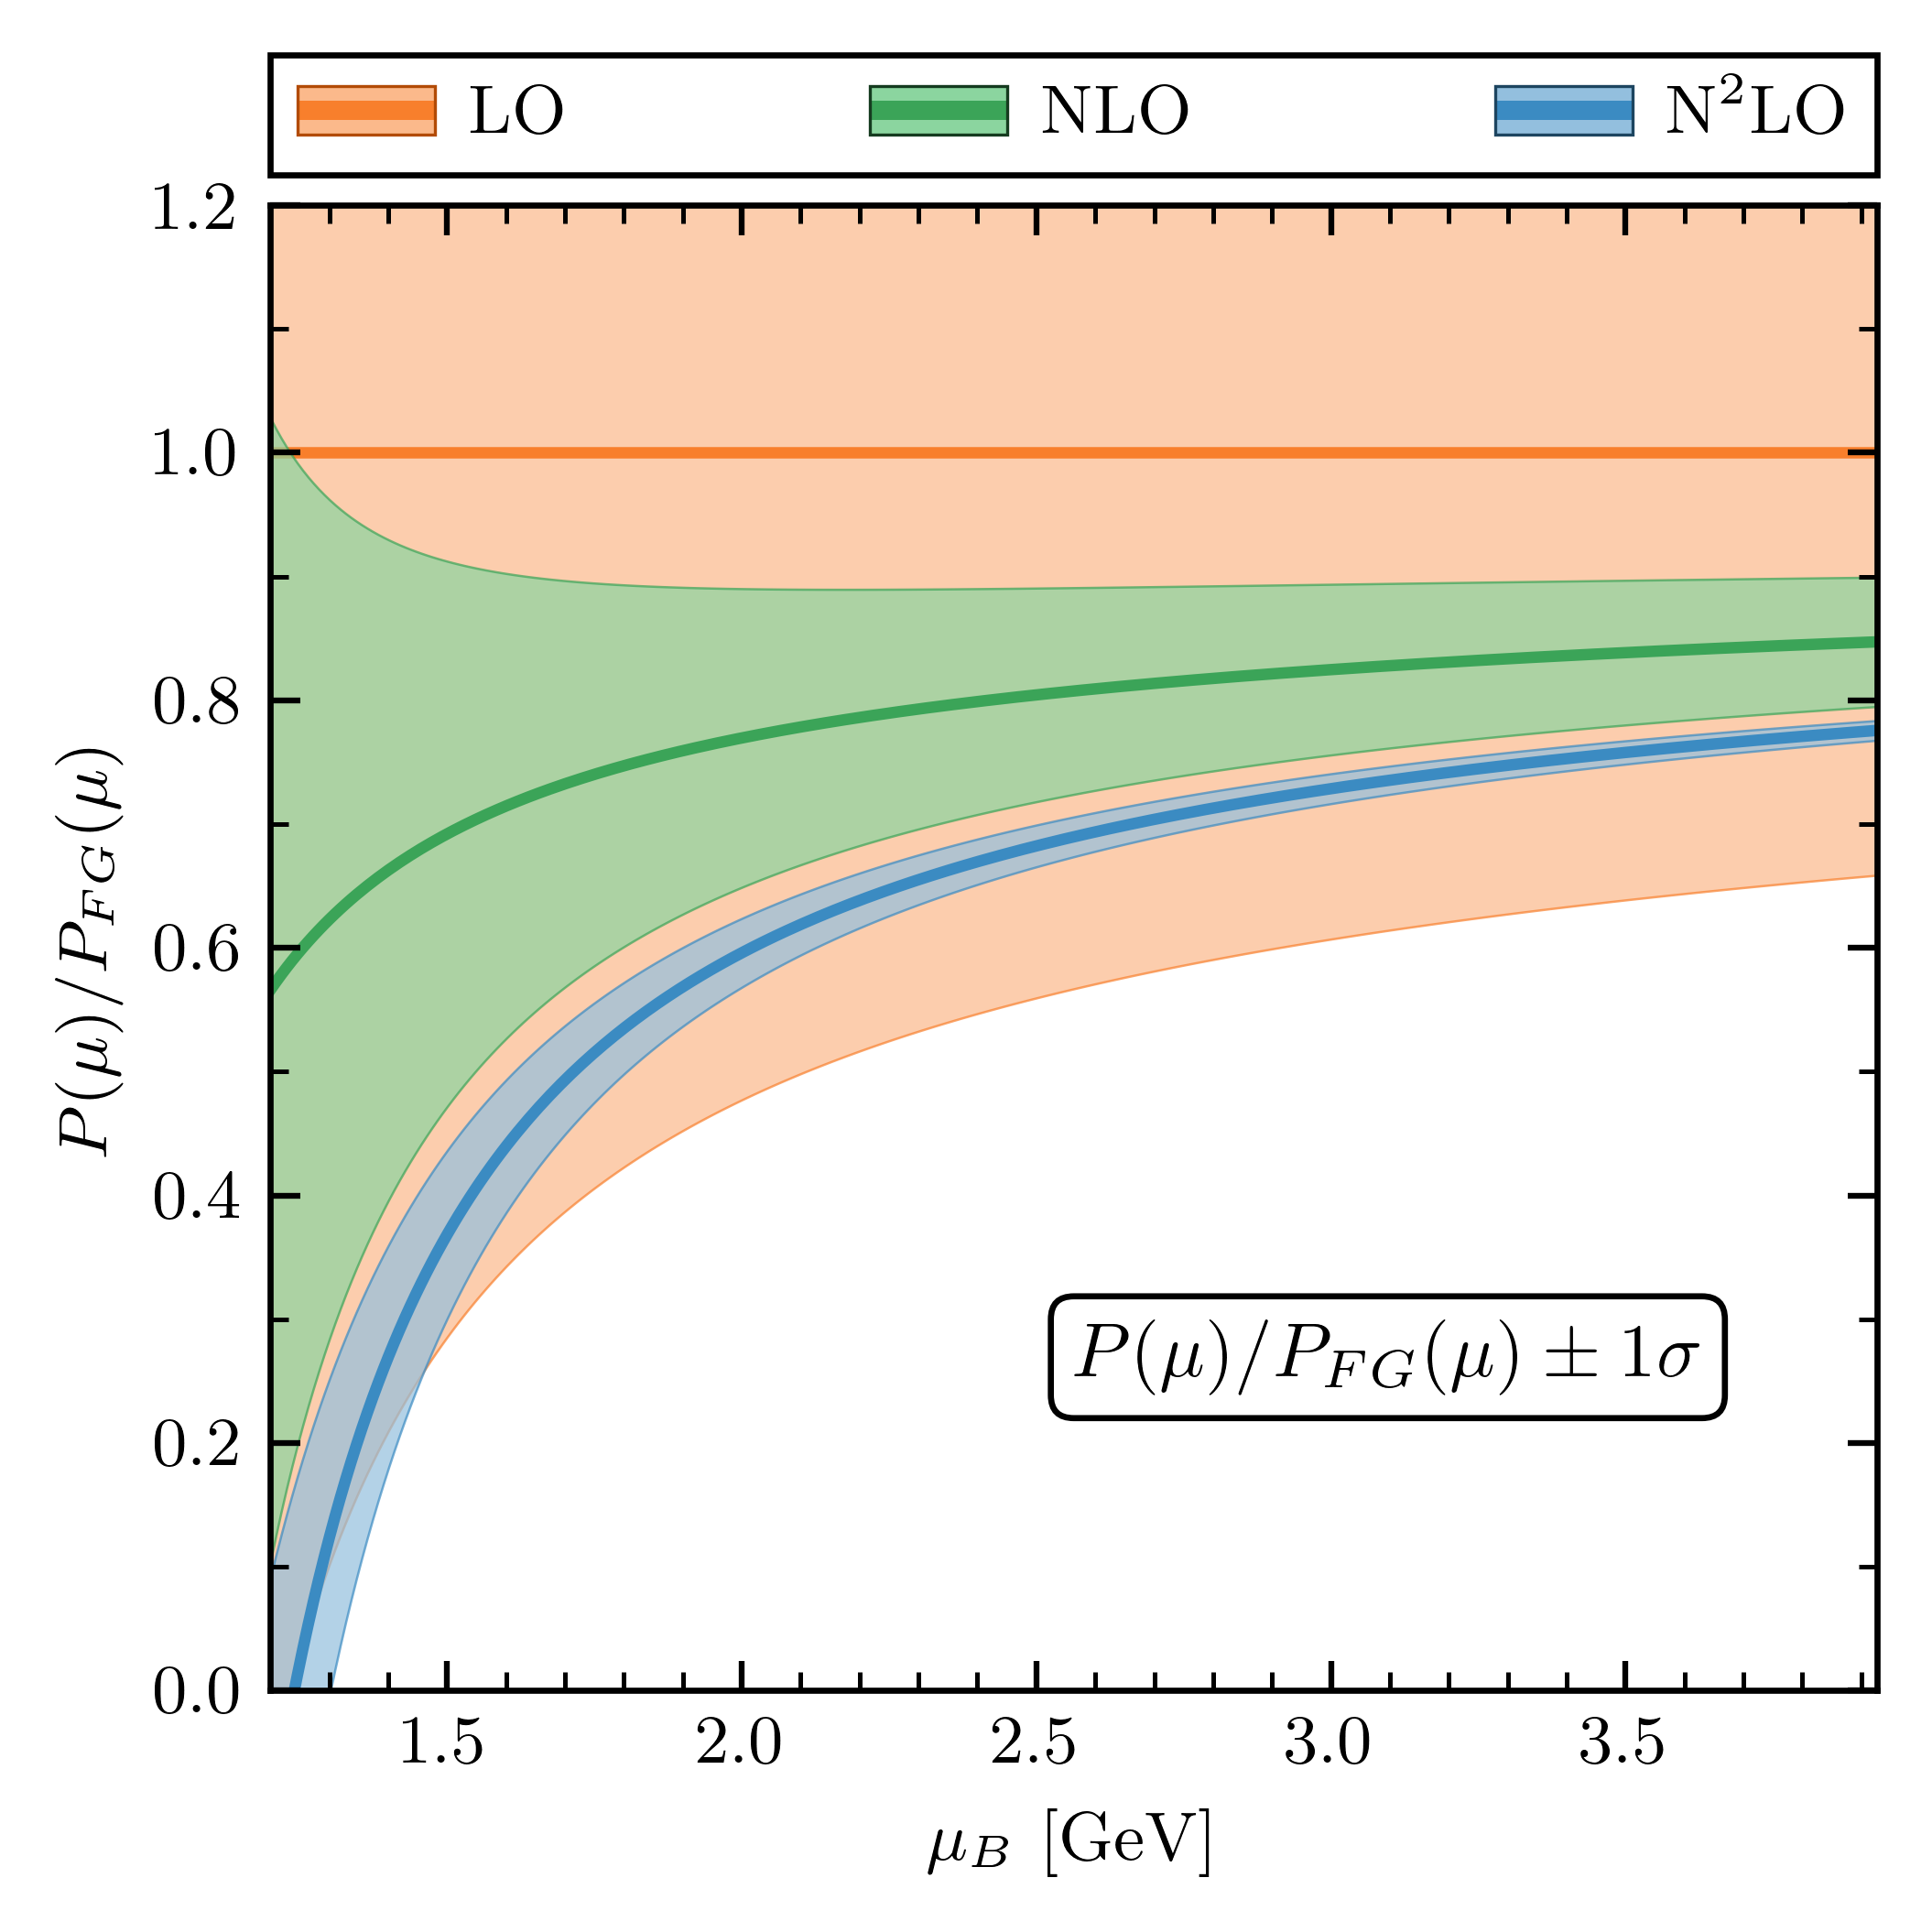

In [68]:
labels = [r'LO', r'NLO', r'N$^{2}$LO']

# proof that the data is correct
#print(pqcd.yref(X)*(pqcd.c_0(x) + pqcd.c_1(x)*pqcd.expQ(X)) - data[:,1])

fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4), dpi=600)
for i in range(3):
    ax.plot(3.0 * x, data[:, i]/pqcd.yref(X), zorder=i-1, c=colors[i])
    ax.fill_between(3.0 * x, (data[:, i] + 1.0*std[:,i])/pqcd.yref(X), \
                    (data[:, i] - 1.0*std[:,i])/pqcd.yref(X),
                        zorder=i-1, facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth, alpha=0.7)
    ax.set_ylim(0.0,1.2)
    ax.set_xlim(min(3.0 * x), max(3.0 * x))
    ax.set_ylabel(r'$P(\mu)/P_{FG}(\mu)$')
ax.set_xlabel(r'$\mu_{B}$ [GeV]')
title = r'$P(\mu)/P_{FG}(\mu) \pm 1\sigma$'
ax.text(
    0.50, 0.25, title, transform=ax.transAxes, ha='left', va='top',
    multialignment='center', zorder=10, fontsize=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(right=True, top=True, which='both')
add_top_order_legend(fig, ax, ax, order_labels, colors, light_colors, dark_colors)

#fig.savefig('pqcd_pressure_mu.png')

print(std[50,2])

Number of points in training set: 2
Number of points in validation set: 2

Training set: 
 [[0.8864214 ]
 [1.09923077]]

Validation set: 
 [[1.00802676]
 [1.25123746]]
2.2095955489683625
1e-09
Calculated value : 2.7123958277893334
Trained kernel:  RBF(length_scale=11.3)
Scale:  1.867449079439804
Condition number: 8707.44920055697


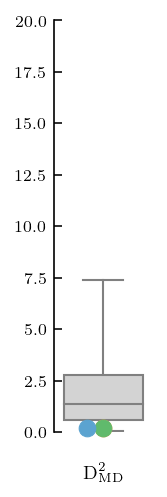

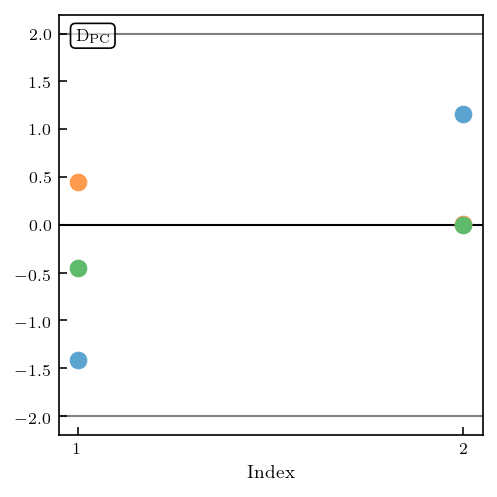

In [69]:
# call the diagnostics here to test before using on number density results
trunc.diagnostics(80, 40)

## $P(n)/P_{FG}(n)$ <a id="calc_p_n"></a>

### Setting up $n$ to obtain corresponding $\mu_{FG}(n)$

In [70]:
# now we would like to get a mu array corresponding to the n we desire
#n = np.linspace(11.2, 16.0, 300) # baryon number density from chiral EFT [fm^-3]
n = np.linspace(0.05, 16.0, 600)
dens = n

# convert this quark number density first
n_q = n*3.0  # n_q [fm^-3]

# convert to GeV^3 for mu_q
conversion_fm3 = ((1000.0)**(3.0))/((197.33)**(3.0)) # [fm^-3]  (do the opposite of this)
n_q = n_q/conversion_fm3  # [GeV^3]

# invert to get mu
_, mu_n, mu_FG = pqcd.inversion(n_mu=n_q)  # [GeV] # these are quark chemical potentials

mU_FG = mu_FG[:,None]   # [GeV] 

/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [71]:
# use the same kernel as before (aka the exact same class), but predict at the new points in n (aka, mu_FG)
std_trunc_pn = np.zeros([len(mU_FG), n_orders])
cov_trunc_pn = np.zeros([len(mU_FG), len(mU_FG), n_orders])
for i, n in enumerate(orders):
        _, std_trunc_pn[:,n] = trunc.trunc_gp.predict(mU_FG, order=n, return_std=True, kind='trunc', \
                                                      pred_noise=True)
        _, cov_trunc_pn[:,:,n] = trunc.trunc_gp.predict(mU_FG, order=n, return_std=False, \
                                                        return_cov=True, kind='trunc', pred_noise=True)
        
# print the kernel parameters
print(trunc.trunc_gp.coeffs_process.kernel_)

# mask the inf values in std_trunc_pn
for j in range(len(orders)):
    for i in range(len(std_trunc_pn)):
        if np.isnan(std_trunc_pn[i,j]) == True or np.isinf(std_trunc_pn[i,j]) == True:
            std_trunc_pn[i,j] = 1e10

RBF(length_scale=11.3)


/Users/alexandra/Documents/EOSBMM/buqeyenm/notebooks/../src/pqcd_reworked.py:119: RuntimeWarning: invalid value encountered in log
  alpha_s = ((4.0*np.pi)/(self.beta0*ell)) * (1.0 - (2.0*beta1*np.log(ell))/(ell*self.beta0**2.0))
/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/gsum/models.py:1340: RuntimeWarning: invalid value encountered in multiply
  return self.ref(X) * ratio_sum * coeff_mean


Text(0.1, 0.9, '$P(n)$ [MeV/fm$^{3}$]')

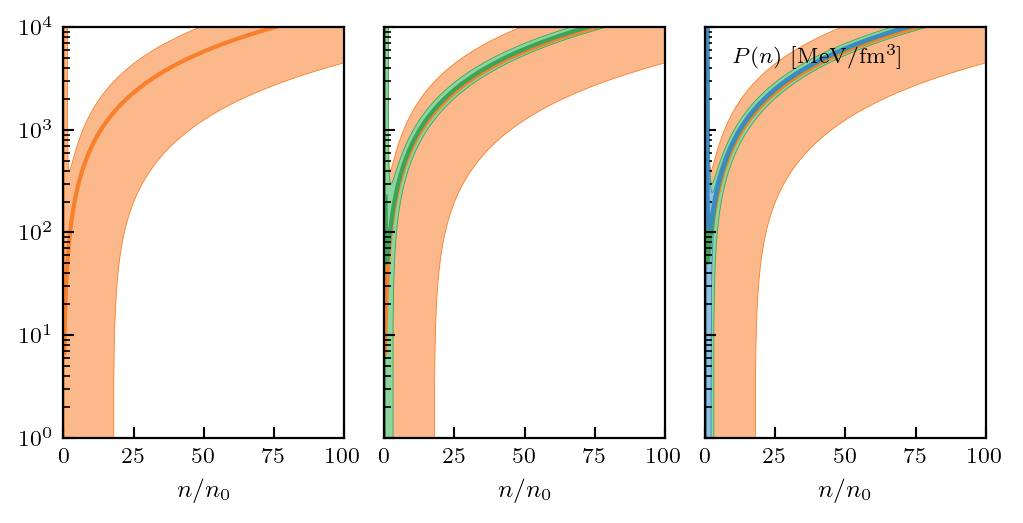

In [72]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(5, 2.5), dpi=200)
conversion = (1000)**4.0/(197.327)**3.0 

# call KLW function for pressure and assign to array
pressure_n_KLW = pqcd.pressure_KLW(mu_FG)
corrected_pressure = np.array([pressure_n_KLW["LO"], pressure_n_KLW["NLO"], pressure_n_KLW["N2LO"]]).T

for i, n in enumerate(orders):
    for j in range(i, 3):
        ax = axes.ravel()[j]
        ax.set_xlim(0.0, 100.0)
        ax.set_yscale('log')
        ax.set_ylim(1.0,10000)
        ax.plot(dens/n0, corrected_pressure[:,i]*conversion, zorder=i, c=colors[i])
        ax.fill_between(dens/n0, corrected_pressure[:, i]*conversion + 1.96*std_trunc_pn[:,i]*conversion, \
                        corrected_pressure[:, i]*conversion - 1.96*std_trunc_pn[:,i]*conversion,
                        zorder=i-1, facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth)
    ax = axes.ravel()[i]
    ax.set_xlabel(r'$n/n_{0}$')
ax.text(0.1, 0.9, r'$P(n)$ [MeV/fm$^{3}$]', ha='left', va='bottom',
           transform=ax.transAxes, fontsize=8)

[1.00000000e+10 1.00000000e+10 1.00000000e+10 1.00000000e+10
 1.00000000e+10 1.00000000e+10 1.00000000e+10 5.00739287e-03
 1.25795315e-03 8.12240507e-04 6.15621912e-04 5.04225248e-04
 4.33017249e-04 3.84035121e-04 3.48618586e-04 3.22067360e-04
 3.01611191e-04 2.85513997e-04 2.72634486e-04 2.62192907e-04
 2.53639305e-04 2.46575270e-04 2.40705502e-04 2.35806744e-04
 2.31707259e-04 2.28272905e-04 2.25397470e-04 2.22995828e-04
 2.20998998e-04 2.19350527e-04 2.18003793e-04 2.16919976e-04
 2.16066505e-04 2.15415862e-04 2.14944646e-04 2.14632844e-04
 2.14463236e-04 2.14420939e-04 2.14493020e-04 2.14668193e-04
 2.14936568e-04 2.15289445e-04 2.15719137e-04 2.16218836e-04
 2.16782485e-04 2.17404684e-04 2.18080601e-04 2.18805901e-04
 2.19576686e-04 2.20389439e-04 2.21240983e-04 2.22128437e-04
 2.23049187e-04 2.24000854e-04 2.24981269e-04 2.25988450e-04
 2.27020583e-04 2.28076007e-04 2.29153196e-04 2.30250744e-04
 2.31367359e-04 2.32501847e-04 2.33653107e-04 2.34820118e-04
 2.36001935e-04 2.371976

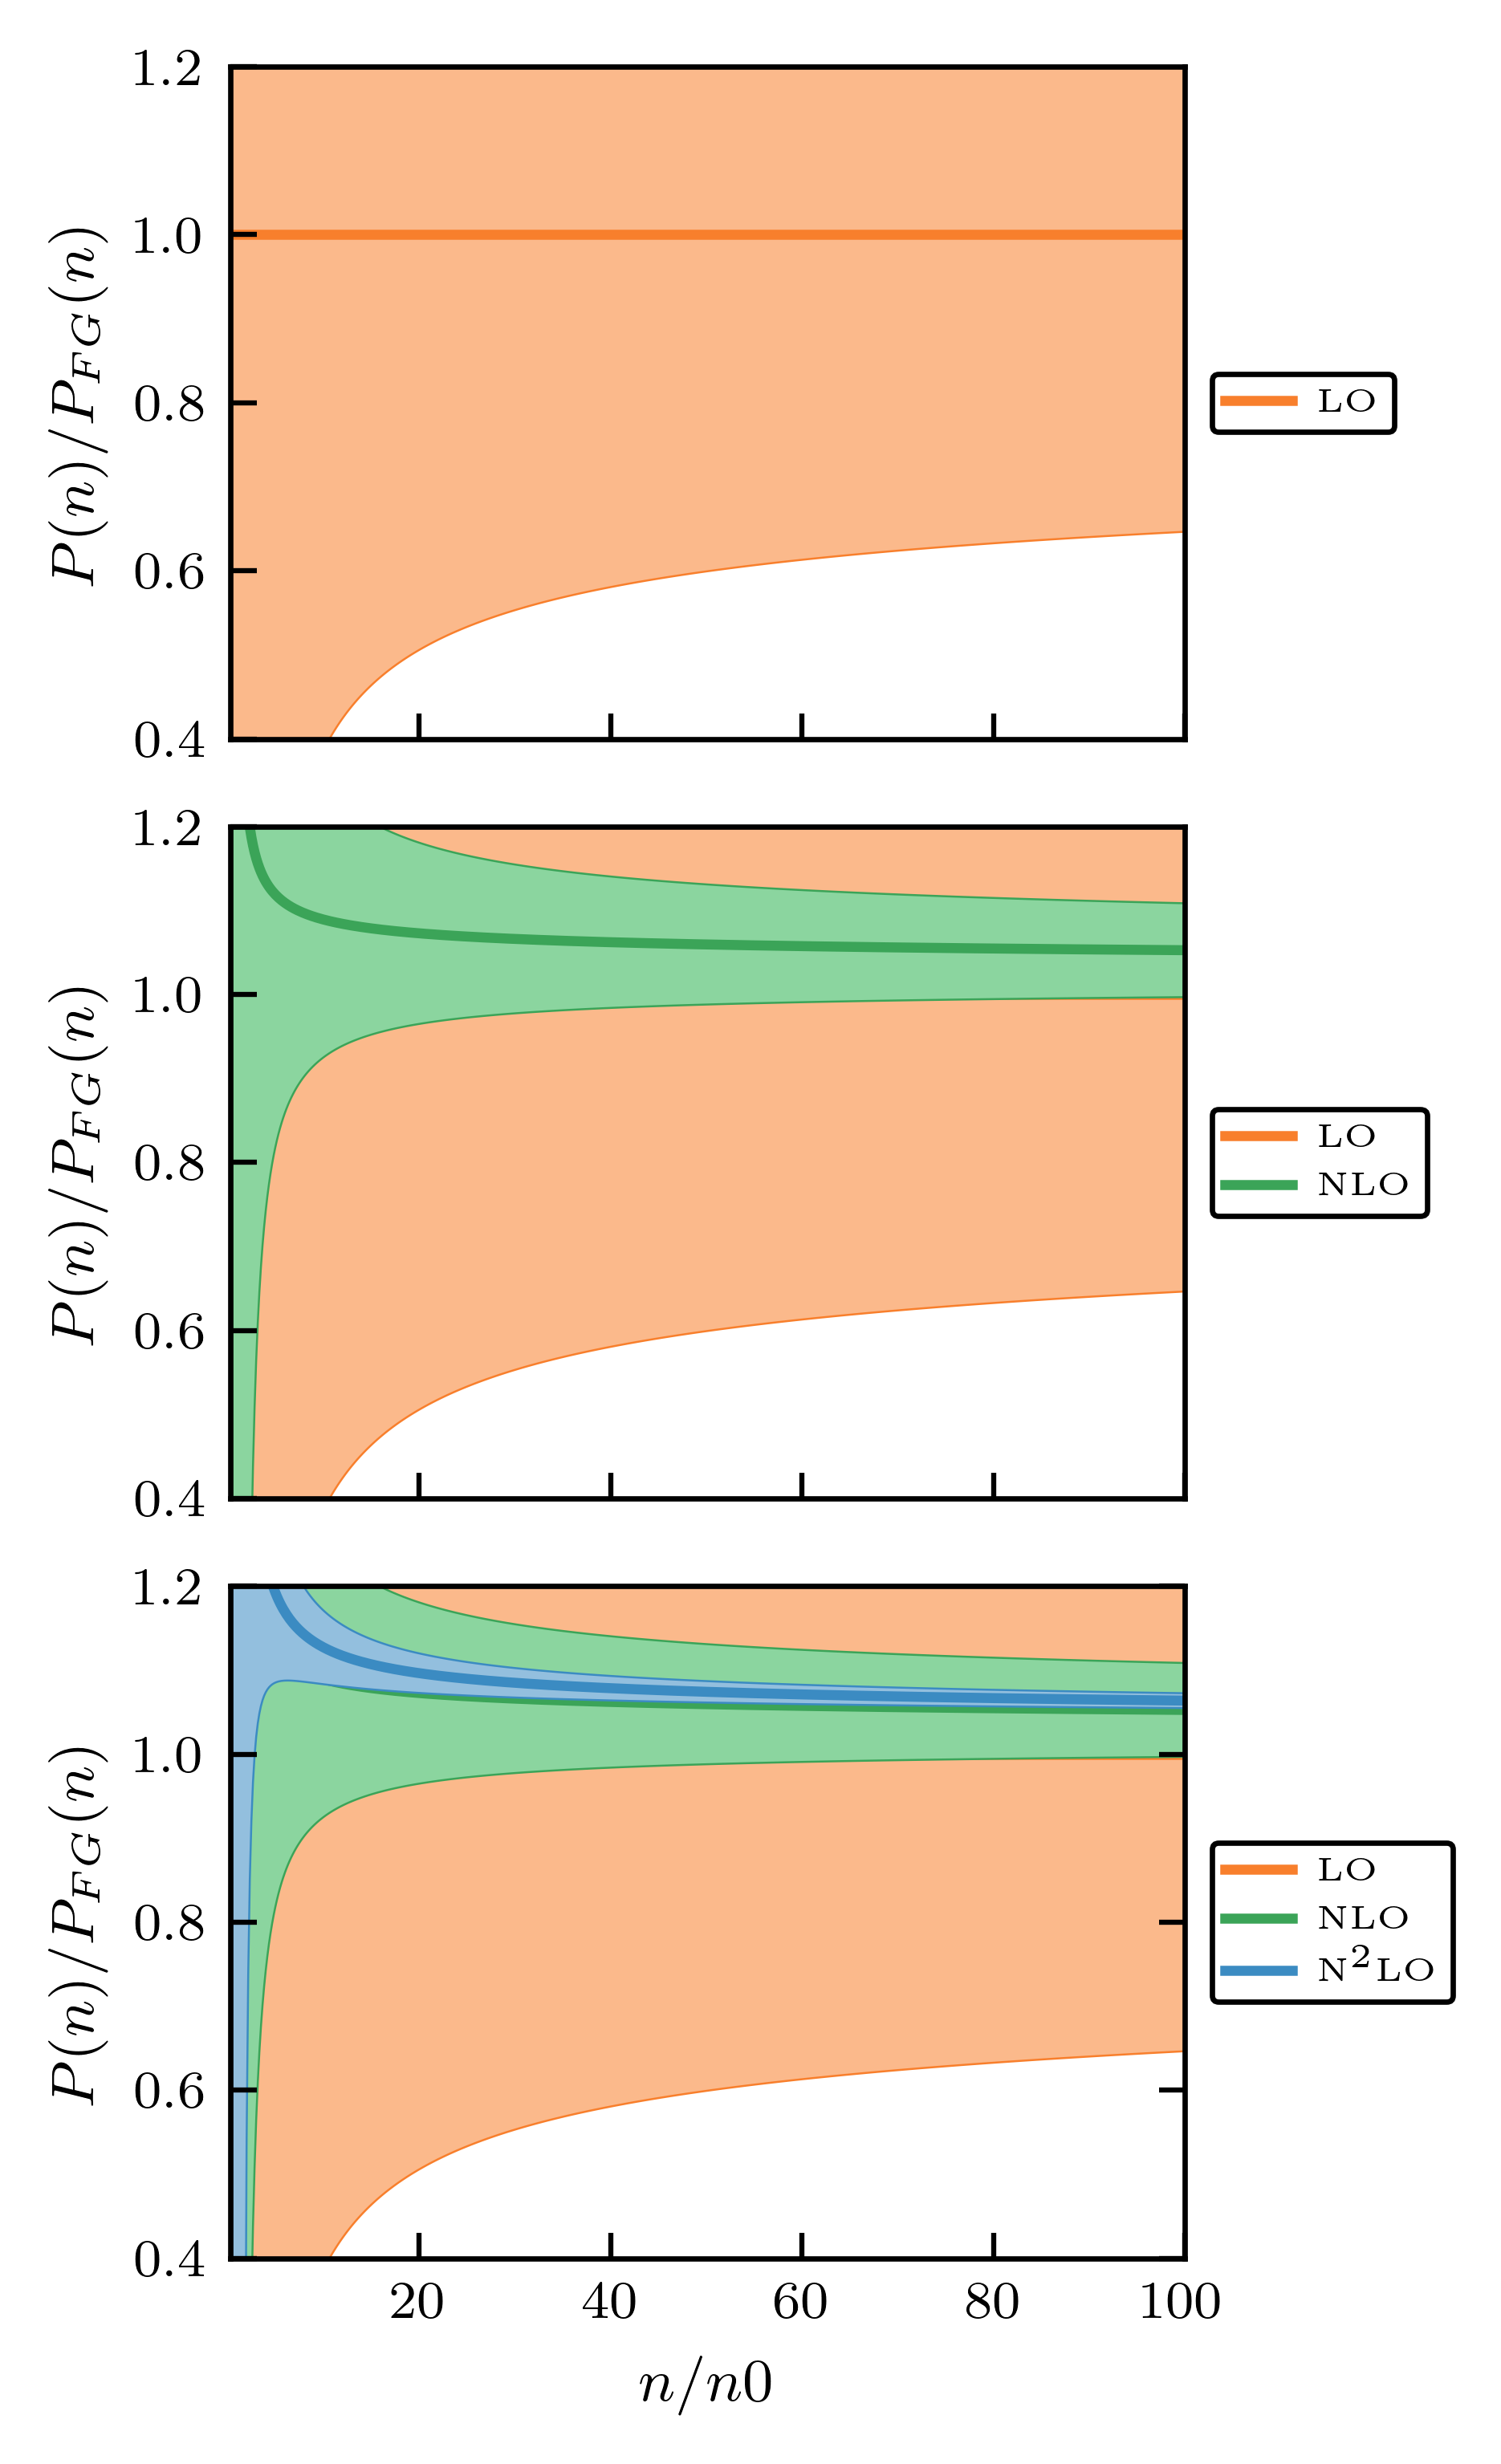

In [73]:
X = mu_n[:,None]
X_FG = mu_FG[:,None]  
labels = [r'LO', r'NLO', r'N$^{2}$LO']
labels_original = [r'LO original', r'NLO original', r'N$^{2}$LO original']

fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(3,5), dpi=600)

for i,n in enumerate(orders):
    for j in range(i, 3):
        ax = axes.ravel()[j]
        ax.plot(dens/n0, corrected_pressure[:, i]/pqcd.yref(X_FG), zorder=i-1, c=colors[i], label=labels[i])
        ax.fill_between(dens/n0, (corrected_pressure[:, i] + 1.0*std_trunc_pn[:,i])/pqcd.yref(X_FG),\
                        (corrected_pressure[:, i] - 1.0*std_trunc_pn[:,i])/pqcd.yref(X_FG),
                        zorder=i-1, facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth)
        ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=5)
    ax = axes.ravel()[i]
    ax.set_ylim(0.4,1.2)
    ax.set_xlim(min(dens)/n0, max(dens)/n0)
    ax.set_ylabel(r'$P(n)/P_{FG}(n)$')
ax.set_xlabel(r'$n/n0$')
ax.tick_params(right=True)

print(std_trunc_pn[:,2])

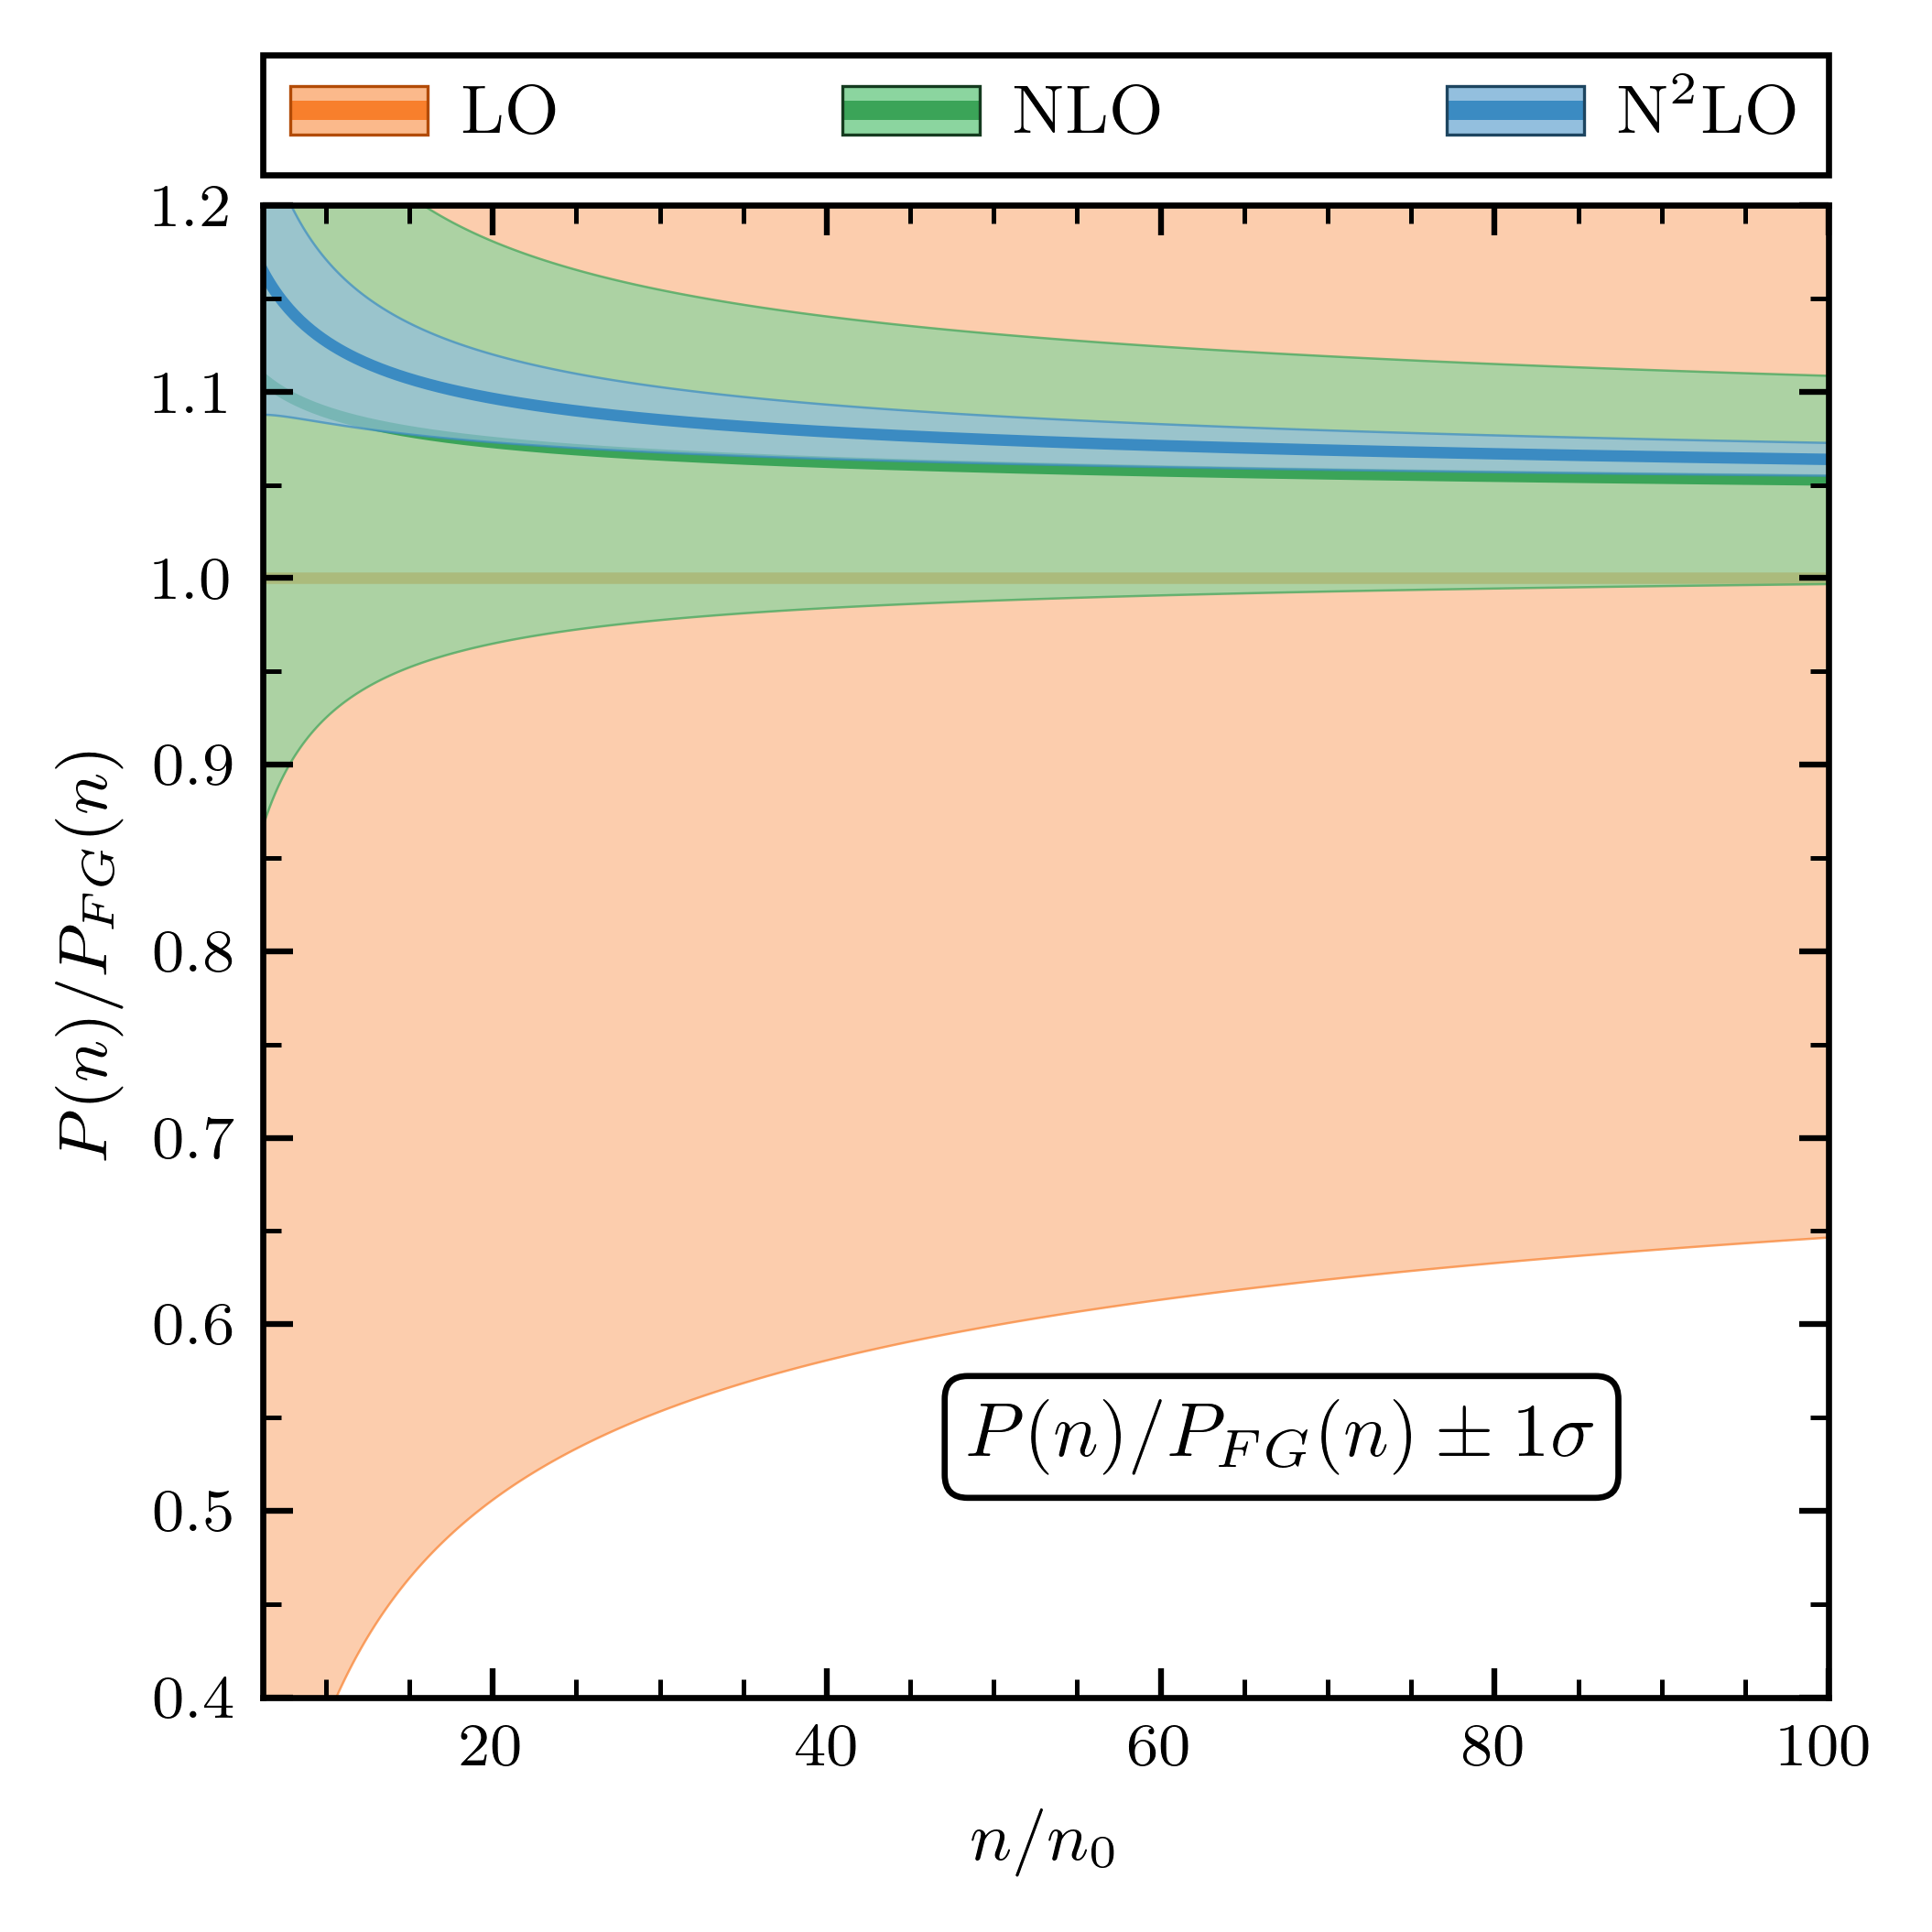

In [74]:
X = mu_n[:,None]
X_FG = mu_FG[:,None]
labels = [r'LO', r'NLO', r'N$^{2}$LO']
labels_original = [r'LO original', r'NLO original', r'N$^{2}$LO original']

fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4), dpi=600)
for i in range(3):
    ax.plot(dens/n0, corrected_pressure[:, i]/pqcd.yref(X_FG), zorder=i-1, c=colors[i], label=labels[i])
    ax.fill_between(dens/n0, (corrected_pressure[:, i] + 1.0*std_trunc_pn[:,i])/pqcd.yref(X_FG), \
                    (corrected_pressure[:, i] - 1.0*std_trunc_pn[:,i])/pqcd.yref(X_FG),
                    zorder=i-1, facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth, alpha=0.7)
    ax.set_ylim(0.4,1.2)
    ax.set_xlim(1.0/n0, max(dens)/n0)
    ax.set_ylabel(r'$P(n)/P_{FG}(n)$')
ax.set_xlabel(r'$n/n_{0}$')
title = r'$P(n)/P_{FG}(n) \pm 1\sigma$'
ax.text(
    0.45, 0.2, title, transform=ax.transAxes, ha='left', va='top',
    multialignment='center', zorder=10, fontsize=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(right=True, top=True, which='both')
add_top_order_legend(fig, ax, ax, order_labels, colors, light_colors, dark_colors, )
#fig.savefig('pqcd_pressure_n.png')

In [75]:
# calculate pQCD values for Table III, X = 1, N2LO
# from scipy.interpolate import interp1d
# p_n_mean_interp = interp1d(dens, corrected_pressure[:,2]*conversion, kind='cubic', fill_value='extrapolate')
# print(p_n_mean_interp(36.0*0.16))
# p_n_std_interp = interp1d(dens, std_trunc[:,2]*conversion, kind='cubic', fill_value='extrapolate')
# print(p_n_std_interp(36.0*0.16))

In [76]:
# store the P_FG(n) values, unscaled, for plotting against the unscaled result of Chiral EFT
pressure_FG = pqcd.yref(mU_FG)*conversion

# write this to a file if correct number of points (avoid overwrite)
if dens.size >= 600:
    np.savez('../data/eos_data/pqcd_fg_data', density=dens, dens_scaled=dens/n0, mean=pressure_FG)
else:
    print('Not saved.')

In [77]:
# save scaled results in an npz file
mean_pressure_scaled = np.zeros([len(dens), 3])
std_pressure_scaled = np.zeros([len(dens), 3])
cov_pressure_scaled = np.zeros([len(dens), len(dens), 3])

scale = pqcd.yref(X_FG)

for i in range(3):
    mean_pressure_scaled[:,i] = corrected_pressure[:,i]/pqcd.yref(X_FG)
    std_pressure_scaled[:,i] = std_trunc_pn[:,i]/pqcd.yref(X_FG)

for i in range(3):
    for j in range(len(dens)):
        for k in range(len(dens)):
            cov_pressure_scaled[j,k,i] = cov_trunc_pn[j,k,i]/(scale[j]*scale[k])

#write this to a file if size is correct
if dens.size >= 600:
    np.savez('../data/eos_data/pressure_pqcd_data_scaled', density=dens, dens_scaled=dens/n0, mean=mean_pressure_scaled, std_dev=std_pressure_scaled, \
             cov=cov_pressure_scaled)
    # open the file here and check it
    npzfile = np.load('../data/eos_data/pressure_pqcd_data_scaled.npz')
    npzfile.files

    print(npzfile['density'].shape, npzfile['dens_scaled'].shape, npzfile['mean'].shape, npzfile['std_dev'].shape, npzfile['cov'].shape)

    print(np.sqrt(np.diag(cov_pressure_scaled[:,:,2])) - std_pressure_scaled[:,2])
else:
    print('Not saved.')

(600,) (600,) (600, 3) (600, 3) (600, 600, 3)
[            nan             inf             inf             inf
             inf             inf             inf  0.00000000e+00
 -4.44089210e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.77555756e-17  0.00000000e+00
  0.00000000e+00  2.77555756e-17  2.77555756e-17  0.00000000e+00
  2.77555756e-17  0.00000000e+00  1.38777878e-17 -1.38777878e-17
  1.38777878e-17  1.38777878e-17  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.38777878e-17  0.00000000e+00  0.00000000e+00
 -1.38777878e-17  1.38777878e-17  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  6.93889390e-18
  0.00000000e+00  0.00000000e+00 -6.93889390e-18  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  6.93889390e-18  0.00000000

In [78]:
# print the whole thing
print('Results at 100*n0:')
print('LO:',(corrected_pressure[:, 0]/pqcd.yref(X_FG))[-1])
print('NLO:',(corrected_pressure[:, 1]/pqcd.yref(X_FG))[-1])
print('N2LO:',(corrected_pressure[:, 2]/pqcd.yref(X_FG))[-1]) 

Results at 100*n0:
LO: 1.0
NLO: 1.0526609453539095
N2LO: 1.0637126151917922


In [79]:
# try printing error bars to ensure no flipping
print('LO:', ((corrected_pressure[:, 0]-std_trunc_pn[:,0])/pqcd.yref(X_FG))[-1])
print('LO:', ((corrected_pressure[:, 0]+std_trunc_pn[:,0])/pqcd.yref(X_FG))[-1])

print('NLO:',((corrected_pressure[:, 1]-std_trunc_pn[:,1])/pqcd.yref(X_FG))[-1])
print('NLO:',((corrected_pressure[:, 1]+std_trunc_pn[:,1])/pqcd.yref(X_FG))[-1])

print('N2LO:',((corrected_pressure[:, 2]-std_trunc_pn[:,2])/pqcd.yref(X_FG))[-1]) 
print('N2LO:',((corrected_pressure[:, 2]+std_trunc_pn[:,2])/pqcd.yref(X_FG))[-1]) 

LO: 0.6464823032935709
LO: 1.3535176967064289
NLO: 0.9968112170302179
NLO: 1.1085106736776011
N2LO: 1.0548893167179383
N2LO: 1.072535913665646


---

### Relative error calculation

We wish to find the place in the pQCD $P(n)$ result that matches the relative error in $\chi$EFT at the densities $1.5n_{0}$, $1.75n_{0}$, and $2n_{0}$. This is done below by importing the chiral data and comparing to the pQCD results calculated in the above sections of this notebook.

In [80]:
# import chiral EFT data
chiral_result = np.load('../data/eos_data/pressure_chiral_data_scaled_2n0.npz')

# interpolate to obtain bands at exactly the required densities
chiral_interp = interp1d(chiral_result['density'], chiral_result['mean'][:,3], \
                         kind='cubic', fill_value='extrapolate')
chiral_low_interp = interp1d(chiral_result['density'], \
                             chiral_result['mean'][:,3]-1.0*chiral_result['std_dev'][:,3], \
                             kind='cubic', fill_value='extrapolate')
chiral_hi_interp = interp1d(chiral_result['density'], \
                            chiral_result['mean'][:,3]+1.0*chiral_result['std_dev'][:,3], \
                           kind='cubic', fill_value='extrapolate')

# evaluate exactly at required densities
chi_mean_15 = chiral_interp(1.5*n0)
chi_low_15 = chiral_low_interp(1.5*n0)
chi_hi_15 = chiral_hi_interp(1.5*n0)

chi_mean_175 = chiral_interp(1.75*n0)
chi_low_175 = chiral_low_interp(1.75*n0)
chi_hi_175 = chiral_hi_interp(1.75*n0)

chi_mean_2 = chiral_interp(2.0*n0)
chi_low_2 = chiral_low_interp(2.0*n0)
chi_hi_2 = chiral_hi_interp(2.0*n0)

# store results and print
chiral_cutoff_15 = {
    'mean': chi_mean_15,
    'lower': chi_mean_15 - chi_low_15,
    'upper': chi_hi_15 - chi_mean_15
}

chiral_cutoff_15 = {
    'mean': chi_mean_15,
    'lower': chi_mean_15 - chi_low_15,
    'upper': chi_hi_15 - chi_mean_15
}


chiral_cutoff_175 = {
    'mean': chi_mean_175,
    'lower': chi_mean_175 - chi_low_175,
    'upper': chi_hi_175 - chi_mean_175
}

chiral_cutoff_2 = {
    'mean': chi_mean_2,
    'lower': chi_mean_2 - chi_low_2,
    'upper': chi_hi_2 - chi_mean_2
}

print('At 1.5*n0, chiral EFT yields the values: \n', chiral_cutoff_15)
print('\nAt 1.75*n0, chiral EFT yields the values: \n', chiral_cutoff_175)
print('\nAt 2.0*n0, chiral EFT yields the values: \n', chiral_cutoff_2)

# now we compare to pQCD EOS values
# print relative error there
rel_err_15 = chiral_cutoff_15['upper']/chiral_cutoff_15['mean']
rel_err_175 = chiral_cutoff_175['upper']/chiral_cutoff_175['mean']
rel_err_2 = chiral_cutoff_2['upper']/chiral_cutoff_2['mean']

print('\nRelative error at 1.5n0: ', rel_err_15, 'and % error: ', rel_err_15*100.)
print('Relative error at 1.75n0: ', rel_err_175, 'and % error: ', rel_err_175*100.)
print('Relative error at 2.0n0: ', rel_err_2, 'and % error: ', rel_err_2*100.)

pqcd_rel_interp = interp1d(dens[12:], std_trunc_pn[12:, 2]/corrected_pressure[12:,2], \
                           kind='cubic', fill_value='extrapolate')
# pqcd_rel_interp = interp1d(dens[70:], std_trunc_pn[70:, 2]/corrected_pressure[70:,2], \
#                            kind='cubic', fill_value='extrapolate')  # for X = 0.5, x0 = 3.0
pqcd_rel_dens_15 = fsolve(lambda n : rel_err_15 - pqcd_rel_interp(n), x0 = 1.0, xtol=1e-08)[0]
pqcd_rel_dens_175 = fsolve(lambda n : rel_err_175 - pqcd_rel_interp(n), x0 = 1.0, xtol=1e-08)[0]
pqcd_rel_dens_2 = fsolve(lambda n : rel_err_2 - pqcd_rel_interp(n), x0 = 1.0, xtol=1e-08)[0]

# print the results
print('\npQCD density location for equal relative error at 1.5n0: ', pqcd_rel_dens_15, '[fm^-3]')
print('pQCD density in terms of n0: ', pqcd_rel_dens_15/n0)
print('Relative error at this exact point: ', pqcd_rel_interp(pqcd_rel_dens_15))
print(pqcd_rel_interp(pqcd_rel_dens_15))
print(rel_err_15 - pqcd_rel_interp(pqcd_rel_dens_15))

print('\npQCD density location for equal relative error at 1.75n0: ', pqcd_rel_dens_175, '[fm^-3]')
print('pQCD density in terms of n0: ', pqcd_rel_dens_175/n0)
print('Relative error at this exact point: ', pqcd_rel_interp(pqcd_rel_dens_175))
print(pqcd_rel_interp(pqcd_rel_dens_175))
print(rel_err_175 - pqcd_rel_interp(pqcd_rel_dens_175))

print('\npQCD density location for equal relative error at 2.0n0: ', pqcd_rel_dens_2, '[fm^-3]')
print('pQCD density in terms of n0: ', pqcd_rel_dens_2/n0)
print('Relative error at this exact point: ', pqcd_rel_interp(pqcd_rel_dens_2))
print(pqcd_rel_interp(pqcd_rel_dens_2))
print(rel_err_2 - pqcd_rel_interp(pqcd_rel_dens_2))

At 1.5*n0, chiral EFT yields the values: 
 {'mean': array(0.07677918), 'lower': 0.02692277470813577, 'upper': 0.02692277470813574}

At 1.75*n0, chiral EFT yields the values: 
 {'mean': array(0.12869826), 'lower': 0.037881710580901104, 'upper': 0.03788171058090112}

At 2.0*n0, chiral EFT yields the values: 
 {'mean': array(0.18173804), 'lower': 0.05111139434934983, 'upper': 0.05111139434934983}

Relative error at 1.5n0:  0.3506520390502583 and % error:  35.06520390502583
Relative error at 1.75n0:  0.2943451637738394 and % error:  29.43451637738394
Relative error at 2.0n0:  0.28123663190575987 and % error:  28.123663190575986

pQCD density location for equal relative error at 1.5n0:  0.39107163771718817 [fm^-3]
pQCD density in terms of n0:  2.444197735732426
Relative error at this exact point:  0.3506520390502264
0.3506520390502264
3.191891195797325e-14

pQCD density location for equal relative error at 1.75n0:  0.4197003789017255 [fm^-3]
pQCD density in terms of n0:  2.6231273681357843


---

## Speed of sound calculation, $c_{s}^{2}(n)$ <a id="cs2"></a>

Analytically, this can be expressed as

$$
c_{s}^{2} = \frac{\partial P}{\partial \varepsilon} = \frac{\partial P}{\partial n}\left[\frac{\partial \varepsilon}{\partial n}\right]^{-1} = \frac{1}{\mu} \frac{\partial P}{\partial n}
$$

We can obtain both of these quantities quite easily, and we can even, instead of taking the derivative of $P$ with respect to $n$, use the logarithmic derivative form of the above equation, which reads as

$$
c_{s}^{2} = \frac{d\ln{\mu}}{d\ln{n}} = \frac{n}{\mu}\frac{\partial \mu}{\partial n}.
$$

Here, we'll need the values of $n$, $\mu$, and $\frac{\partial \mu}{\partial n}$, so let's check to see how convenient it is to obtain these with our new KLW inversion technique. 

For the speed of sound from the GP, we'll eventually need this expression for the energy density,

$$
\varepsilon(n) = n \left[\frac{\varepsilon(n_{i})}{n_{i}} + \int_{n_{i}}^{n}\frac{P(n')}{n'^{2}} dn' \right]
$$

where we are integrating the results from $P(n)$ KLW calculations, and using an initial density to make sure that we obtain the proper boundary condition for the integral.

In [81]:
# calculate the speed of sound in the same manner as done for the mixed model to find any inconsistencies
from utils import speed_of_sound
import scipy.integrate as scint
import scipy.interpolate as scinterp

hbarc = 197.327 # MeV fm

# cut the pressure linspace from 0.05,16.0 to 11.2,16.0 or so
cs2_cut = np.where([i >= 11.2 for i in dens])[0][0]

In [82]:
# dictionary of dictionary of pressures
pres_dict_FG = {
    'mean': corrected_pressure[cs2_cut:,0]*conversion,
    'std_dev': std_trunc_pn[cs2_cut:,0]*conversion
}
pres_dict_NLO = {
    'mean': corrected_pressure[cs2_cut:,1]*conversion,
    'std_dev': std_trunc_pn[cs2_cut:,1]*conversion
}

pres_dict_N2LO = {
    'mean': corrected_pressure[cs2_cut:,2]*conversion,
    'std_dev': std_trunc_pn[cs2_cut:,2]*conversion
}

# total dictionary of dictionaries
pres_dict = {
    'FG': pres_dict_FG,
    'NLO': pres_dict_NLO,
    'N2LO': pres_dict_N2LO
}

def boundary_conditions(dens, pres_dict, index=0): 
    
    # constants
    hbarc = 197.327 # Mev fm
    
    # unpack dictionary
    pres_FG = pres_dict['FG']
    pres_NLO = pres_dict['NLO']
    pres_N2LO = pres_dict['N2LO']
    
    # set up new dictionary for eps(n) BCs
    edens_FG = dict()
    edens_NLO = dict()
    edens_N2LO = dict()
    
    # make mu_FG array from the selected density array
    n_q = dens*3.0  # n_q [fm^-3]

    # convert to GeV^3 for mu_q
    conversion_fm3 = ((1000.0)**(3.0))/((197.33)**(3.0)) # [fm^-3]  (do the opposite of this)
    n_q = n_q/conversion_fm3  # [GeV^3]

    # invert to get mu
    _, _, mu_FG = pqcd.inversion(n_mu=n_q)  # [GeV] # these are quark chemical potentials
    mU_FG = mu_FG[:, None]
    
    # FG BCs
    edens_FG['mean'] = ((3.0 / (2 * np.pi**2.0)) * (3.0 * np.pi**2.0 * dens/2.0)**(4.0/3.0) * hbarc)[index]
    edens_FG['lower'] = (dens*3*1000.*mu_FG - (pres_dict_FG['mean']-pres_dict_FG['std_dev']))[index]
    edens_FG['upper'] = (dens*3*1000.*mu_FG - (pres_dict_FG['mean']+pres_dict_FG['std_dev']))[index]
    
    # NLO BCs
    edens_NLO['mean'] = ((pqcd.mu_1(mU_FG)[:,0]*1000.) * 3.0 * dens - \
                         (pres_dict_NLO['mean'] - pres_dict_FG['mean']))[index]
    edens_NLO['lower'] = ((pqcd.mu_1(mU_FG)[:,0]*1000.) * 3.0 * dens \
    - ((pres_dict_NLO['mean'] - pres_dict_FG['mean']) - \
       (pres_dict_NLO['std_dev']-pres_dict_FG['std_dev'])))[index]
    edens_NLO['upper'] = ((pqcd.mu_1(mU_FG)[:,0]*1000.) * 3.0 * dens \
    - ((pres_dict_NLO['mean'] - pres_dict_FG['mean']) + \
       (pres_dict_NLO['std_dev']-pres_dict_FG['std_dev'])))[index]
    
    # N2LO BCs
    edens_N2LO['mean'] = ((pqcd.mu_2(mU_FG)[:,0]*1000.) * 3.0 * dens - \
                          (pres_dict_N2LO['mean'] - pres_dict_NLO['mean']))[index]
    
    edens_N2LO['lower'] = ((pqcd.mu_2(mU_FG)[:,0]*1000.) * 3.0 * dens - \
                           ((pres_dict_N2LO['mean'] - pres_dict_NLO['mean']) - \
                            (pres_dict_N2LO['std_dev']-pres_dict_NLO['std_dev'])))[index]
   
    edens_N2LO['upper'] = ((pqcd.mu_2(mU_FG)[:,0]*1000.) * 3.0 * dens - \
                           ((pres_dict_N2LO['mean'] - pres_dict_NLO['mean']) + \
                            (pres_dict_N2LO['std_dev']-pres_dict_NLO['std_dev'])))[index]
        
    # add corrections to single out each order
    edens_NLO['mean'] += edens_FG['mean']
    edens_NLO['lower'] += edens_FG['lower']
    edens_NLO['upper'] += edens_FG['upper']
    
    edens_N2LO['mean'] += edens_NLO['mean']
    edens_N2LO['lower'] += edens_NLO['lower']
    edens_N2LO['upper'] += edens_NLO['upper']

    # combine into dictionary and return
    edens_dict = {
        'FG': edens_FG,
        'NLO': edens_NLO,
        'N2LO': edens_N2LO
    }
    
    return mu_FG, mU_FG, edens_dict

# run the boundary condition function
mu_cs2_FG, mU_cs2_FG, edens_dict = boundary_conditions(dens[cs2_cut:], pres_dict, index=-1)
print(edens_dict['N2LO'])

# run speed of sound and plot
dens_cs2, cs2_FG, cs2_log_FG, edens_FG, mu_cs2_FG = \
speed_of_sound(dens[cs2_cut:], pres_dict_FG, edens_dict['FG'], integrate='backward')
_, cs2_NLO, cs2_log_NLO, edens_NLO, mu_cs2_NLO = \
speed_of_sound(dens[cs2_cut:], pres_dict_NLO, edens_dict['NLO'], integrate='backward')
_, cs2_N2LO, cs2_log_N2LO, edens_N2LO, mu_cs2_N2LO = \
speed_of_sound(dens[cs2_cut:], pres_dict_N2LO, edens_dict['N2LO'], integrate='backward')

{'mean': 47637.52750259489, 'lower': 47766.80672601489, 'upper': 47508.24823853746}


FG endpoint: 0.33334791880224657
NLO endpoint: 0.3313253197175072
N2LO endpoint 0.32573056635465036


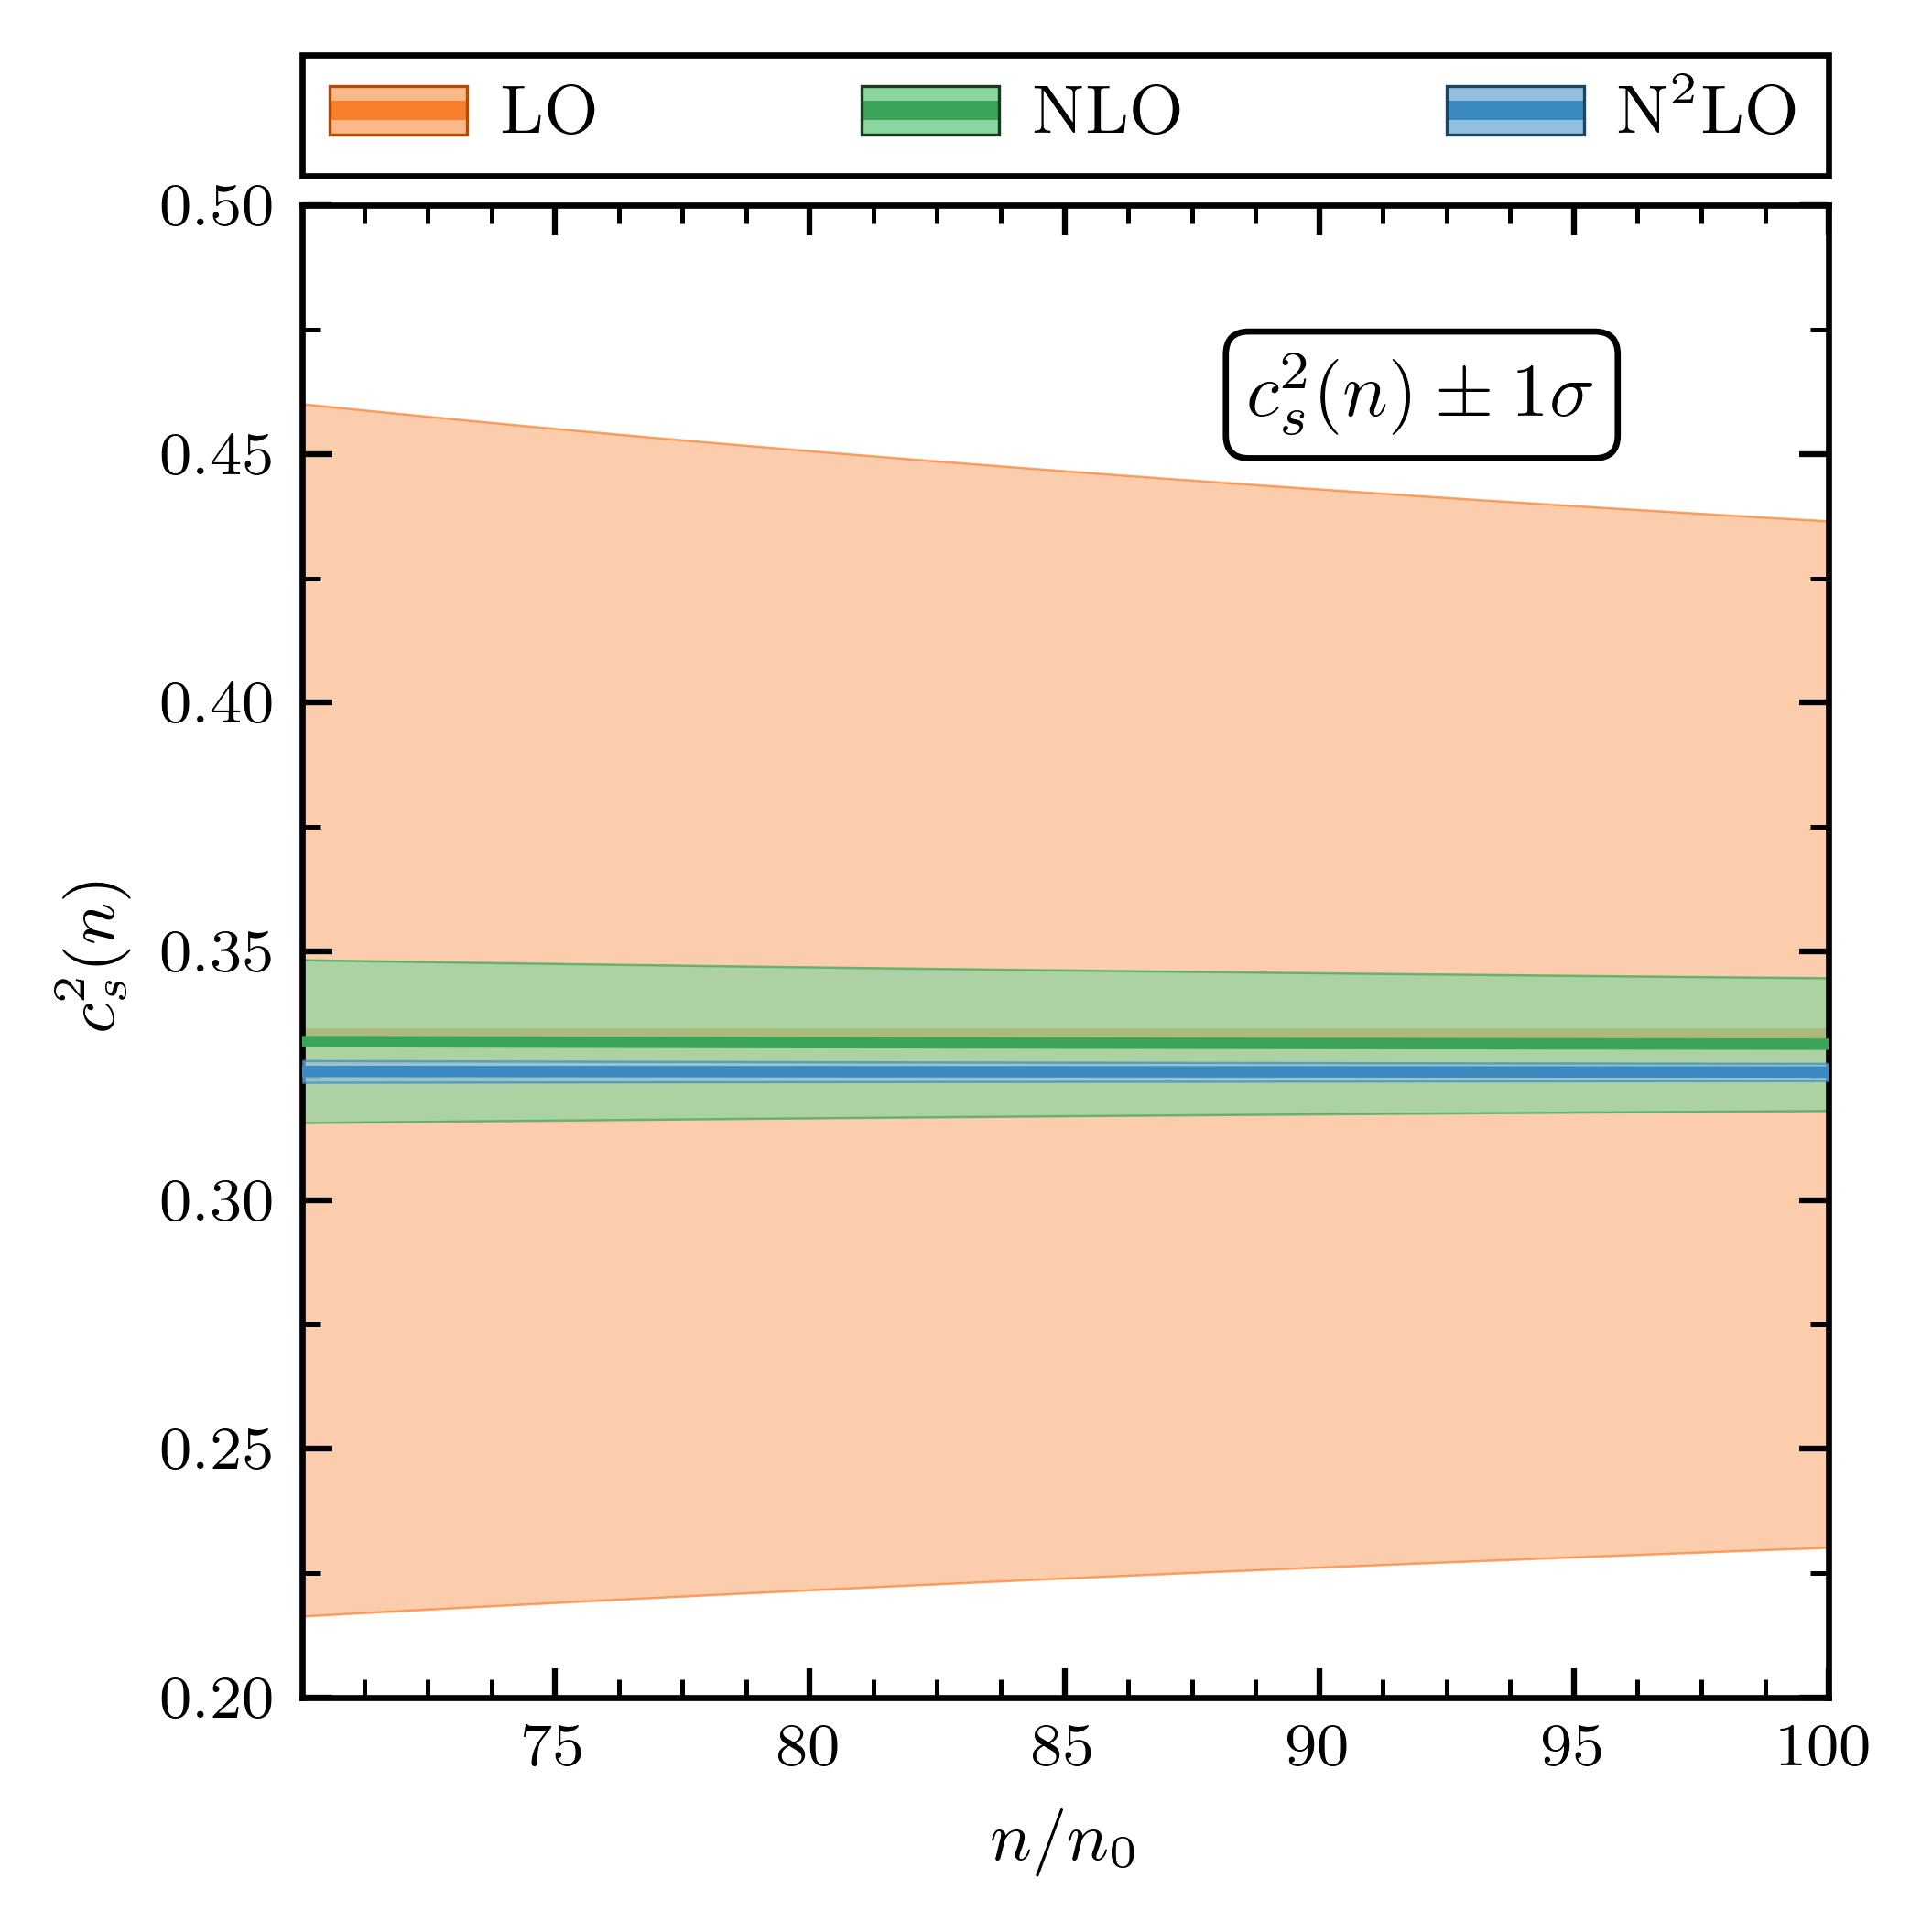

In [83]:
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4), dpi=600)
ax.axhline(y=(1.0/3.0), color='grey', linestyle='dotted', zorder=-1, alpha=0.2)
ax.plot(dens_cs2/n0, cs2_log_FG['mean'], c=colors[0], zorder=1)
ax.fill_between(dens_cs2/n0, cs2_log_FG['lower'], cs2_log_FG['upper'],
                    zorder=0, facecolor=light_colors[0], edgecolor=colors[0], lw=edgewidth, alpha=0.7)
ax.plot(dens_cs2/n0, cs2_NLO['mean'], c=colors[1], zorder=3)
ax.fill_between(dens_cs2/n0, cs2_log_NLO['lower'], cs2_log_NLO['upper'],
                    zorder=2, facecolor=light_colors[1], edgecolor=colors[1], lw=edgewidth, alpha=0.7)
ax.plot(dens_cs2/n0, cs2_log_N2LO['mean'], c=colors[2], zorder=5)
ax.fill_between(dens_cs2/n0, cs2_log_N2LO['lower'], cs2_log_N2LO['upper'],
                    zorder=4, facecolor=light_colors[2], edgecolor=colors[2], lw=edgewidth, alpha=0.7)

ax.set_ylim(0.2,0.5)
ax.set_xlim(min(dens_cs2/n0), max(dens_cs2/n0))
ax.set_ylabel(r'$c_{s}^{2}(n)$')
ax.set_xlabel(r'$n/n_{0}$')
title = r'$c_{s}^{2}(n) \pm 1\sigma$'
ax.text(
    0.62, 0.90, title, transform=ax.transAxes, ha='left', va='top',
    multialignment='center', zorder=10, fontsize=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(right=True, top=True, which='both')
add_top_order_legend(fig, ax, ax, order_labels, colors, light_colors, dark_colors)
fig.savefig('pqcd_cs2n.png')
print('FG endpoint:', cs2_log_FG['mean'][-1])
print('NLO endpoint:', cs2_log_NLO['mean'][-1])
print('N2LO endpoint', cs2_log_N2LO['mean'][-1])

## Save the data for the GP package <a id="gp_data"></a>

In [84]:
if dens[0] == 1.0:
    np.savez('../data/eos_data/pqcd_cs2_1.0', density=dens, mean=cs2_N2LO['mean'], \
             lower=cs2_N2LO['lower'], upper=cs2_N2LO['upper'])
    # test viewing
    npzfile = np.load('../data/eos_data/pqcd_cs2_1.0.npz')
    npzfile.files
elif dens[0] == 0.05:
    np.savez('../data/eos_data/pqcd_cs2_11.2', density=dens_cs2, mean=cs2_log_N2LO['mean'], \
             lower=cs2_log_N2LO['lower'], upper=cs2_log_N2LO['upper']) 
else:
    print('Not saved.')

Created by: Alexandra Semposki, 
14 March 2024